# Beehive Sensor Data Anylsis
- Please help me to design a proper solution for the following problem. I am a beekeeper and i am measuring my beehive with sensors. We have the temperature, humidity values inside the beehive box and we weight the whole beehive in kg. All measerung points are measured every 10 min. With this given data set espially with the weigh value, I want to find out when I have feeded the bees with sugar water. The indicator is that the weight will increase sharply with around 3-5 kg (just in a few measuring points). Those feeding event should be stored in a new dataframe/table/database. What should i do step by step. take time to think about it

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from hampel import hampel

Load Data

In [16]:
data = pd.read_csv(".streamlit/24-09-21_beehive_cleaned.csv").sort_values(by='created_at')
print(data.dtypes)
data

created_at         object
entry_id            int64
weight            float64
humidity          float64
temperature       float64
year                int64
month               int64
day                 int64
month_day          object
weight_cleaned    float64
dtype: object


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned
0,2020-10-14 15:03:37+00:00,1,49.63,78.0,13.1,2020,10,14,10-14,49.63
1,2020-10-14 15:13:41+00:00,2,49.77,95.0,20.3,2020,10,14,10-14,49.77
2,2020-10-14 15:23:45+00:00,3,49.79,95.0,23.1,2020,10,14,10-14,49.79
3,2020-10-14 15:33:49+00:00,4,49.78,86.0,23.4,2020,10,14,10-14,49.78
4,2020-10-14 15:43:53+00:00,5,49.77,79.0,23.5,2020,10,14,10-14,49.77
...,...,...,...,...,...,...,...,...,...,...
166144,2024-09-21 16:42:14+00:00,172760,42.73,75.0,28.9,2024,9,21,09-21,42.73
166145,2024-09-21 16:52:15+00:00,172761,42.73,75.0,28.9,2024,9,21,09-21,42.73
166146,2024-09-21 17:02:17+00:00,172762,42.73,75.0,28.8,2024,9,21,09-21,42.73
166147,2024-09-21 17:12:18+00:00,172763,42.73,75.0,28.8,2024,9,21,09-21,42.73


## Identify sharp changing weight loss/gain Events 

In [17]:
# Identify feeding events by looking for large changes in weight
# Calculate weight difference using the diff method
data['weight_diff'] = data['weight_cleaned'].diff()

# Identify feeding events (weight change greater than or equal to 3 kg, either increase or decrease)
feeding_events = data[data['weight_diff'].abs() >= 1.5]


# Only show feeding events from August 1st, 2024 onwards
feeding_events_august = feeding_events[feeding_events['created_at'] >= '2024-07-01']
display(feeding_events_august)

,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff
157066,2024-07-13 13:48:04+00:00,163682,22.31,76.0,31.0,2024,7,13,07-13,22.31,-12.79
157067,2024-07-13 13:58:11+00:00,163683,18.25,73.0,21.3,2024,7,13,07-13,18.25,-4.06
157068,2024-07-13 14:08:17+00:00,163684,21.38,78.0,18.3,2024,7,13,07-13,21.38,3.13
157079,2024-07-13 16:08:38+00:00,163695,24.02,75.0,35.2,2024,7,13,07-13,24.02,2.63
157608,2024-07-17 08:31:01+00:00,164224,24.17,74.0,33.1,2024,7,17,07-17,24.17,1.53
157980,2024-07-20 06:50:56+00:00,164596,30.07,78.0,33.0,2024,7,20,07-20,30.07,4.54
158306,2024-07-22 13:18:49+00:00,164922,34.52,77.0,33.5,2024,7,22,07-22,34.52,5.13
158887,2024-07-26 15:52:36+00:00,165503,35.68,76.0,34.7,2024,7,26,07-26,35.68,2.92


In [18]:
def identify_quick_weight_changes_events(data, window_size=6, weight_change_threshold=1, time_threshold='30min'):
    """
    Identify feeding events by looking for large changes in weight and aggregate them by time intervals.
    
    Parameters:
    - data: DataFrame containing the beehive data.
    - window_size: The size of the rolling window to calculate the median weight.
    - weight_change_threshold: The threshold for identifying significant weight changes (in kg).
    - time_threshold: The time interval to aggregate events (default is 30 minutes).
    
    Returns:
    - quick_weight_changes_events: DataFrame containing the aggregated feeding events.
    """
    # Calculate weight difference with a rolling window
    data['weight_diff'] = data['weight_cleaned'] - data['weight_cleaned'].rolling(window=window_size).median()

    # Identify feeding events (weight change greater than or equal to the threshold)
    quick_weight_changes_events = data[data['weight_diff'].abs() >= weight_change_threshold]

    # Aggregate events by time intervals
    quick_weight_changes_events['created_at'] = pd.to_datetime(quick_weight_changes_events['created_at'])
    quick_weight_changes_events = quick_weight_changes_events.sort_values(by='created_at')
    
    # display(quick_weight_changes_events)
    # Initialize the first event
    current_start = quick_weight_changes_events.iloc[0]['created_at']
    current_end = quick_weight_changes_events.iloc[0]['created_at']
    
    print(current_start)
    print(current_end)
    print(len(quick_weight_changes_events))
    
    
    
    for i in range(1, len(quick_weight_changes_events)):
        current_time = quick_weight_changes_events.iloc[i]['created_at']
        previous_time = quick_weight_changes_events.iloc[i - 1]['created_at']
        
        # Check if the current time is within the time threshold of the previous time
        if (current_time - previous_time) <= pd.Timedelta(time_threshold):
            # Update the end date of the current event
            current_end = current_time
            
        else:
            # add to the data frame row where created_on is current_start a new column new_date with the value of current_end
            quick_weight_changes_events.loc[quick_weight_changes_events['created_at'] == current_start, 'end_date'] = current_end
            quick_weight_changes_events.loc[quick_weight_changes_events['created_at'] == current_start, 'event_type'] = "rapid weight change"
            # # delete the row from quick_weight_changes_events where created_on is current_time
            # quick_weight_changes_events = quick_weight_changes_events[quick_weight_changes_events['created_at'] != current_end]
        
            current_start = current_time
            current_end = current_time
        
    
    return quick_weight_changes_events.dropna(subset=['end_date'])

# Call the function and display the results
quick_weight_changes_events = identify_quick_weight_changes_events(data)


# save the data to a csv file called "rapid_weight_changes_events.csv"
quick_weight_changes_events.to_csv(".streamlit/rapid_weight_changes_events.csv", index=False)

start_date='2024-07-01'
# Filter feeding events from the specified start date onwards
quick_weight_changes_events_august = quick_weight_changes_events[quick_weight_changes_events['created_at'] >= start_date]
display(quick_weight_changes_events_august)

2020-12-24 14:55:31+00:00
2020-12-24 14:55:31+00:00
314


C:\Users\timwy\AppData\Local\Temp\ipykernel_22100\604718898.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quick_weight_changes_events['created_at'] = pd.to_datetime(quick_weight_changes_events['created_at'])


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff,end_date,event_type
157066,2024-07-13 13:48:04+00:00,163682,22.31,76.0,31.0,2024,7,13,07-13,22.31,-12.810,2024-07-13 14:08:17+00:00,rapid weight change
157079,2024-07-13 16:08:38+00:00,163695,24.02,75.0,35.2,2024,7,13,07-13,24.02,2.630,2024-07-13 16:28:41+00:00,rapid weight change
157608,2024-07-17 08:31:01+00:00,164224,24.17,74.0,33.1,2024,7,17,07-17,24.17,1.600,2024-07-17 08:41:02+00:00,rapid weight change
157740,2024-07-18 06:54:06+00:00,164356,25.96,78.0,31.5,2024,7,18,07-18,25.96,1.360,2024-07-18 07:04:08+00:00,rapid weight change
157980,2024-07-20 06:50:56+00:00,164596,30.07,78.0,33.0,2024,7,20,07-20,30.07,4.535,2024-07-20 07:10:59+00:00,rapid weight change
158306,2024-07-22 13:18:49+00:00,164922,34.52,77.0,33.5,2024,7,22,07-22,34.52,5.145,2024-07-22 13:38:52+00:00,rapid weight change
158887,2024-07-26 15:52:36+00:00,165503,35.68,76.0,34.7,2024,7,26,07-26,35.68,3.065,2024-07-26 16:12:39+00:00,rapid weight change


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff
157019,2024-07-13 05:57:00+00:00,163635,35.07,76.0,26.2,2024,7,13,07-13,35.07,-0.055
157020,2024-07-13 06:06:56+00:00,163636,35.06,76.0,26.2,2024,7,13,07-13,35.06,-0.010
157021,2024-07-13 06:16:57+00:00,163637,35.08,76.0,26.2,2024,7,13,07-13,35.08,0.010
157022,2024-07-13 06:26:59+00:00,163638,35.07,76.0,26.2,2024,7,13,07-13,35.07,0.000
157023,2024-07-13 06:37:00+00:00,163639,35.06,76.0,26.3,2024,7,13,07-13,35.06,-0.010
...,...,...,...,...,...,...,...,...,...,...,...
157108,2024-07-13 20:59:18+00:00,163724,24.00,76.0,33.9,2024,7,13,07-13,24.00,-0.010
157109,2024-07-13 21:09:20+00:00,163725,24.00,76.0,33.9,2024,7,13,07-13,24.00,-0.005
157110,2024-07-13 21:19:21+00:00,163726,24.00,76.0,33.9,2024,7,13,07-13,24.00,0.000
157111,2024-07-13 21:29:22+00:00,163727,23.99,76.0,33.7,2024,7,13,07-13,23.99,-0.010


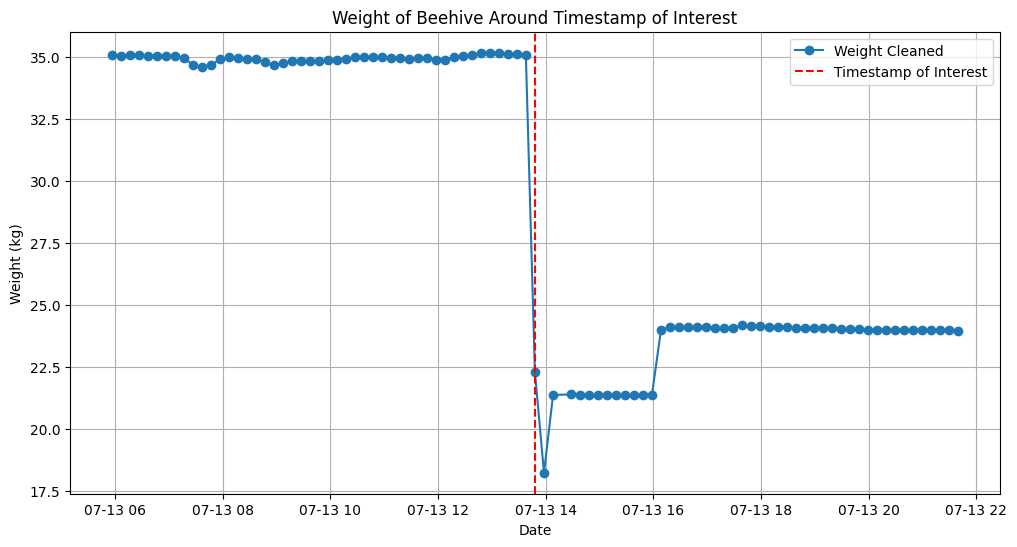

In [19]:
# Define the timestamp of interest
timestamp_of_interest = '2024-07-13 13:48:04+00:00'

# Convert the 'created_at' column to datetime if it is not already
data['created_at'] = pd.to_datetime(data['created_at'])

# Define a time window around the timestamp of interest (e.g., 1 hour before and after)
time_window = pd.Timedelta(hours=8)

# Filter the data for the time window around the timestamp of interest
filtered_data = data[(data['created_at'] >= pd.to_datetime(timestamp_of_interest) - time_window) &
                     (data['created_at'] <= pd.to_datetime(timestamp_of_interest) + time_window)]

# Display the filtered data
display(filtered_data)

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['created_at'], filtered_data['weight_cleaned'], marker='o', linestyle='-', label='Weight Cleaned')
plt.axvline(pd.to_datetime(timestamp_of_interest), color='r', linestyle='--', label='Timestamp of Interest')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Weight of Beehive Around Timestamp of Interest')
plt.grid(True)
plt.legend()
plt.show()

# Identify Bee forage events where the bees collecting nectar slowly over the day and the weight of the beehive slowly increases

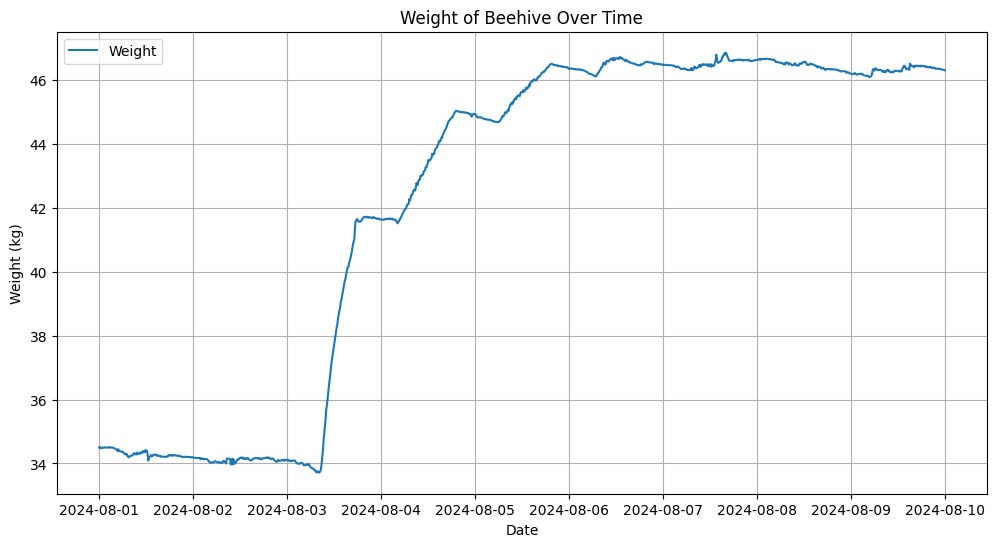

In [20]:
# Plot the weight_cleaned data for August 1st, 2024 until august 10st, 2024
# Filter the data for the specified date range
data_august = data[(data['created_at'] >= '2024-08-01') & (data['created_at'] <= '2024-08-10')]
plt.figure(figsize=(12, 6))
plt.plot(data_august['created_at'], data_august['weight_cleaned'], label='Weight')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Weight of Beehive Over Time')
plt.grid(True)
plt.legend()
plt.show()


In [21]:
# Identify Bee forage events where the bees collecting nectar slowly over the day and the weight of the beehive slowly increases
# Calculate the difference with a period of 18 values
data['weight_diff_period_18'] = data['weight_cleaned'].diff(periods=36)

# Identify forage events where the rolling mean weight increases by at least 1 kg over a 6-hour window
forage_events = data[data['weight_diff_period_18'] >= 1.5]
# Only show forage events from August 1st, 2024 onwards
forage_events_august = forage_events[forage_events['created_at'] >= '2024-08-01']
display(forage_events_august)


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff,weight_diff_period_18
159886,2024-08-03 09:58:48+00:00,166502,35.69,70.0,33.9,2024,8,3,08-03,35.69,0.615,1.69
159887,2024-08-03 10:08:49+00:00,166503,35.83,70.0,34.4,2024,8,3,08-03,35.83,0.535,1.86
159888,2024-08-03 10:18:51+00:00,166504,36.01,70.0,34.8,2024,8,3,08-03,36.01,0.475,2.07
159889,2024-08-03 10:28:52+00:00,166505,36.20,69.0,35.1,2024,8,3,08-03,36.20,0.440,2.26
159890,2024-08-03 10:38:54+00:00,166506,36.42,69.0,35.5,2024,8,3,08-03,36.42,0.500,2.47
...,...,...,...,...,...,...,...,...,...,...,...,...
160042,2024-08-04 12:12:30+00:00,166658,43.49,70.0,33.9,2024,8,4,08-04,43.49,0.140,1.53
160047,2024-08-04 13:02:37+00:00,166663,43.69,70.0,33.8,2024,8,4,08-04,43.69,0.165,1.56
160057,2024-08-04 14:42:51+00:00,166673,44.06,70.0,33.3,2024,8,4,08-04,44.06,0.150,1.52
160071,2024-08-04 17:03:11+00:00,166687,44.65,70.0,33.0,2024,8,4,08-04,44.65,0.140,1.50
